In [22]:
require 'Utils'
require 'Net1'
require 'VGG'
require 'optim'

In [23]:
local dtype = 'torch.DoubleTensor'

VGG_net = load_VGG();
model = BasicConvNet2()
netsav = model:clone('weight', 'bias')
local params, grad_params = model:getParameters()
local crit = nn.MSECriterion():type(dtype)

-- Set up some variables we will use below
local train_loss_history = {}

-- Contains all the meta parameters
opt = {num_iterations=5, print_every=1, learning_rate=0.01, batch_size = 4, layers = {3,9}, display_size=96, num_val_images=10}

--Triming the network will the last required layer 
trim_net(VGG_net, opt.layers[#opt.layers])

-- Get a minibatch and run the model forward, maybe timing it
im_batch, x = create_hypercolumn_dataset_random_bw(opt.batch_size, VGG_net, opt.layers);
uv_images, y_images = create_yuv_images(im_batch,28,28)
uv_images = uv_images + 0.5

-- Datatype standardization 
x, uv_images = x:type(dtype), uv_images:type(dtype)

----------------------------------------------------------------------------
-- Loss function that we pass to an optim method
----------------------------------------------------------------------------
local function f(w)
--  assert(w == params)
  grad_params:zero()

--   -- Get a minibatch and run the model forward, maybe timing it
--   local im_batch, x = create_hypercolumn_dataset_random_bw(opt.batch_size, VGG_net, opt.layers);
--   local uv_images, y_images = create_yuv_images(im_batch,28,28)
  
--   -- Datatype standardization 
--   x, uv_images = x:type(dtype), uv_images:type(dtype)

  local scores = model:forward(x)
  local loss   = crit:forward(scores, uv_images)

  -- Run the Criterion and model backward to compute gradients, maybe timing it
  local grad_scores = crit:backward(scores, uv_images)
  model:backward(x, grad_scores)

  return loss, grad_params
end

-------------------------------------------------------------------------------
-- Train the model!
-------------------------------------------------------------------------------
local optim_config = {learningRate = opt.learning_rate}
local num_iterations = opt.num_iterations
for i = 1, num_iterations do

  -- Take a gradient step and maybe print
  -- Note that adam returns a singleton array of losses
  local _, loss = optim.adam(f, params, optim_config)
  table.insert(train_loss_history, loss[1])
  if opt.print_every > 0 and i % opt.print_every == 0 then
    local msg = ' i = %d / %d, loss = %f'
    local args = {msg,  i, num_iterations, loss[1]}
    print(string.format(unpack(args)))
  end
end


Successfully loaded ../../Data/VGG_caffe/VGG_ILSVRC_16_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3
conv2_2: 128 128 3 3
conv3_1: 256 128 3 3


conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


 i = 1 / 5, loss = 0.010128	


 i = 2 / 5, loss = 0.081543	


 i = 3 / 5, loss = 0.047846	


 i = 4 / 5, loss = 0.021184	


 i = 5 / 5, loss = 0.024624	


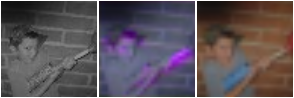

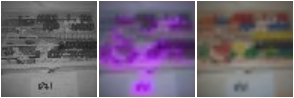

In [24]:
uv_op = model.output - 0.5
for i = 2,3 do
    size = 96
    itorch.image({image.scale(y2rgb(image.rgb2y(im_batch[i])),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_op[i],1)),size,size),
                  image.scale(image.yuv2rgb(torch.cat(y_images[i],uv_images[i]-0.5,1)),size,size)})
    -- itorch.image(image.scale(im_batch[i],size,size))
end

Input, Output, Original	


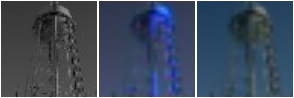

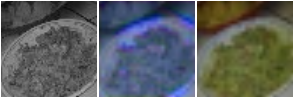

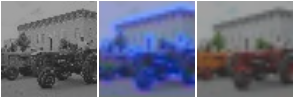

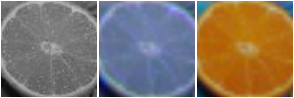

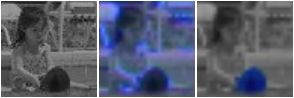

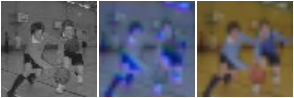

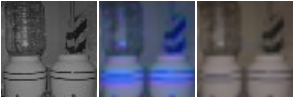

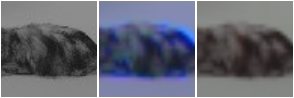

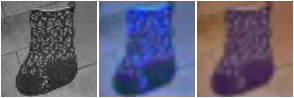

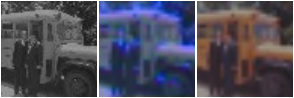

In [25]:
display_validation_results(VGG_net, model, opt)

In [26]:
require 'hdf5'
-- local myFile = hdf5.open('../../model/shallow_net.h5', 'w')
-- local options = hdf5.DataSetOptions()
-- -- --options:setChunked(32, 32)
-- options:setDeflate()
-- myFile:write('shallow_net', model, options)
-- myFile:close()
torch.save('../../model/shallow_net.t7', netsav)

Input, Output, Original	


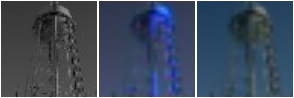

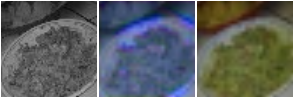

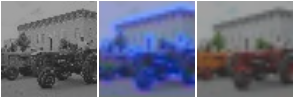

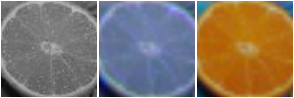

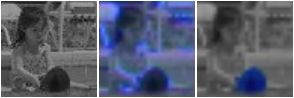

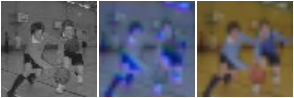

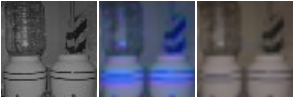

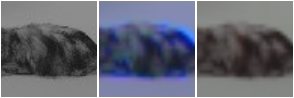

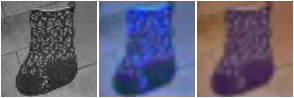

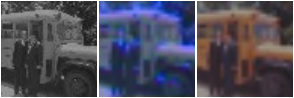

In [27]:
model_load = torch.load('../../model/shallow_net.t7')
display_validation_results(VGG_net, model_load, opt)